#### Deployment code

In [2]:
# input video, output mask
from stenographic_mask_generator import RunStenography, RestoreVideo

In [4]:
# Generate masks (stored as array)
filename = "cyclegan_test"
style_index = 1
mode = 'cyclegan'
fps = 25
display = False
stenographic_masks_stored = RunStenography(filename, style_index, mode, fps, display)

Video generated, filename:  cyclegan_test_cgan.mp4


In [5]:
stenographic_masks_stored

[array([[[ 0.07843138, -0.01176471, -0.04313726],
         [ 0.04313726,  0.02352941, -0.03137255],
         [-0.00392157,  0.01568627,  0.03529412],
         ...,
         [ 0.00392157,  0.01960785, -0.04313725],
         [ 0.02745099,  0.03137255, -0.02745099],
         [ 0.04705883,  0.0509804 , -0.03137255]],
 
        [[ 0.05882353, -0.03137255, -0.03529412],
         [ 0.02745098, -0.01568627, -0.02745098],
         [ 0.02352941, -0.01960784, -0.03137255],
         ...,
         [-0.00392157, -0.00392157, -0.04313725],
         [ 0.01960785,  0.03529412, -0.01960785],
         [ 0.00392157,  0.02352942, -0.04313726]],
 
        [[-0.00392157, -0.02352941, -0.02745098],
         [ 0.01960785, -0.02745098, -0.04705882],
         [ 0.05098039, -0.02745098, -0.05882353],
         ...,
         [-0.02352941, -0.01176471, -0.05098039],
         [-0.01568627,  0.02352942, -0.03921569],
         [ 0.00392157,  0.01176471, -0.03529412]],
 
        ...,
 
        [[-0.03921568, -0.02352941

In [6]:
from stenographic_mask_generator import RunStenography, RestoreVideo
# Restore original video
filename = "cyclegan_test"
style_index = 1
mode = 'cyclegan'
fps = 25
display = False
RestoreVideo(stenographic_masks_stored, filename, style_index, mode, fps, display)

Video generated, filename:  cyclegan_test_restored.mp4


In [ ]:
# Clean up util files
DeleteProcessingFiles(style_index)

#### Development code

##### Implementation steps
1. Load video, parse each video into frames
2. Apply CycleGAN/ForegroundRemoval to each frame, store frame --> returned to user
3. Compute stenographic mask (difference between original and new frame) --> stored on blockchain; return tensor for storage
4. Accept mask tensor as argument to retain original video

Functionality:
* CycleGAN
* Foreground removal (to be developed)
* Constraints: mp4 file format, audio not retained

In [1]:
# imports
import cv2
import os, glob, shutil
from PIL import Image
import matplotlib, random
import torch, torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from vision.cyclegan import CYCLEGAN
from vision.video import FrameGeneration, VideoGeneration

In [2]:
# arguments
filename = "cyclegan_test"
style_index = 1
mode = 'cyclegan'
fps = 25
display = True

# options
styles = ["apple2orange", "horse2zebra", "style_monet", "style_vangogh", "summer2winter_yosemite"]
modes = ['cyclegan', 'foregroundremoval']

In [3]:
# parse video into frames
FrameGeneration(filename)

In [3]:
# Load frames
filenames = []
for f in glob.iglob("data/"+str(filename) + "/*"):
    filenames.append(f)

In [5]:
# perform style transfer via CycleGAN
if mode == 'cyclegan':
    CYCLEGAN(
            destination_style = styles[style_index], 
            source_image = "data/"+str(filename),
            num = int(len(filenames)*2),
            )

In [6]:
# Video generation
VideoGeneration(
    filename = filename,
    frame_ref = './vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(1)+'_fake.png', 
    mode = mode, 
    style = styles[style_index], 
    fps = fps,
)

In [4]:
# Mask generation
def MaskGenerator(fakeimg_path, realimg_path, display):
    # processing original images
    transform = T.Compose([T.ToTensor()])

    img_fake = cv2.cvtColor(cv2.imread(fakeimg_path), cv2.COLOR_BGR2RGB)
    img_rgb_fake = transform(img_fake)
    img_array_floating_fake = np.array(img_rgb_fake[:,:,:])

    img_real = cv2.cvtColor(cv2.imread(realimg_path), cv2.COLOR_BGR2RGB)
    img_rgb_real = transform(img_real)
    img_array_floating_real = np.array(img_rgb_real[:,:,:])

    # generating stenographic mask
    masked_img = []
    for j in range(img_rgb_real.shape[2]): # for each pixel along width
        sub_masked_img = []
        for i in range(img_rgb_real.shape[1]): # for each pixel along height
            tmp=[]
            for h in range(img_rgb_fake.shape[0]): # for each image channel
                tmp.append(img_array_floating_fake[h][i][j]-img_array_floating_real[h][i][j])
            sub_masked_img.append(tmp)
        masked_img.append(sub_masked_img) 

    masked_img_array = np.array(masked_img)

    if display == True:
        print("Ground truth image")
        plt.imshow(img_real)
        plt.show()
        print("Encrypted image")
        plt.imshow(img_fake)
        plt.show()
        print("Stenographic mask image")
        plt.imshow(masked_img_array[:,:,:])
        plt.show()
        print("Stenographic mask array")
        print(masked_img_array)
        
    return masked_img_array

In [58]:
# Video Restoration
def Restoration(masked_img_array, fakeimg_path, store_path, display):
    
    transform = T.Compose([T.ToTensor()])

    img_fake = cv2.cvtColor(cv2.imread(fakeimg_path), cv2.COLOR_BGR2RGB)
    img_rgb_fake = transform(img_fake)
    img_array_floating_fake = np.array(img_rgb_fake[:,:,:])

    # masked_img_array

    # restoring original from (fake, mask)
    restored_img = []
    for j in range(img_rgb_fake.shape[2]): # for each pixel along width
        sub_masked_img = []
        for i in range(img_rgb_fake.shape[1]): # for each pixel along height
            tmp=[]
            for h in range(img_rgb_fake.shape[0]): # for each image channel
                tmp.append(img_array_floating_fake[h][j][i]-masked_img_array[i][j][h])
            sub_masked_img.append(tmp)
        restored_img.append(sub_masked_img) 

    restored_img_array = np.array(restored_img)

    if display == True:
        print("Restored image")
        plt.imshow(restored_img_array)
        plt.show()
        

    # reshape array for video export
    restored_img = []
    for j in range(restored_img_array.shape[2]): # channel
        sub_masked_img = []
        for h in range(restored_img_array.shape[0]): # width
            tmp=[]
            for i in range(restored_img_array.shape[1]): # height
                tmp.append(restored_img_array[h][i][j])
            sub_masked_img.append(tmp)
        restored_img.append(sub_masked_img) 
    restored_img = np.array(restored_img)
    

    matplotlib.image.imsave(store_path, restored_img_array)
    
    return restored_img_array

In [5]:
# Generate stenographic masks
if mode == 'cyclegan':
    stenographic_masks_stored = []
    for i in range(0,int(len(filenames))):
        masked_img_array = MaskGenerator(
                            fakeimg_path = './vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(i+1)+'_fake.png',
                            realimg_path = './vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(i+1)+'_real.png',
                            display = False
                            )
        stenographic_masks_stored.append(masked_img_array)
    

In [60]:
# Apply stenographic mask onto encrpted video to restore original video for display
if mode == 'cyclegan':

    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    WIDTH, HEIGHT = cv2.cvtColor(cv2.imread('./vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(1)+'_fake.png'), cv2.COLOR_BGR2RGB).shape[1], cv2.cvtColor(cv2.imread('./vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(1)+'_fake.png'), cv2.COLOR_BGR2RGB).shape[0]
    video=cv2.VideoWriter("data/"+str(filename)+"_restored.mp4", fourcc, fps,(WIDTH, HEIGHT))
    
    for i in range(0,int(len(filenames))):
        restored_img_array = Restoration(
                                    masked_img_array = stenographic_masks_stored[i], 
                                    fakeimg_path = './vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(i+1)+'_fake.png',  
                                    store_path = './vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(i+1)+'_restored.png',
                                    display = False,
                                )
        
        video.write(cv2.imread('./vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(i+1)+'_restored.png'))
        
    
    cv2.destroyAllWindows()
    video.release()
    

In [61]:
# delete folder in cyclegan directory with style folder name, delete visions folder inside visions folder
shutil.rmtree("./vision/vision", ignore_errors=True)
shutil.rmtree('./vision/cycle_gan/results/'+str(styles[style_index]), ignore_errors=True)

#### Stenography mask demo on sample image

Ground truth image


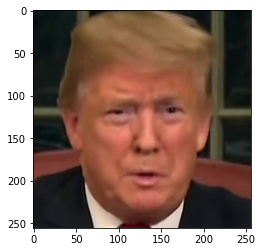

Encrypted image


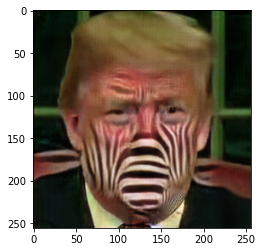

Stenographic mask image


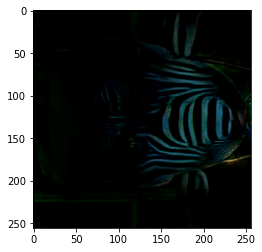

Stenographic mask array
[[[ 0.07843138 -0.01176471 -0.04313726]
  [ 0.04313726  0.02352941 -0.03137255]
  [-0.00392157  0.01568627  0.03529412]
  ...
  [ 0.00392157  0.01960785 -0.04313725]
  [ 0.02745099  0.03137255 -0.02745099]
  [ 0.04705883  0.0509804  -0.03137255]]

 [[ 0.05882353 -0.03137255 -0.03529412]
  [ 0.02745098 -0.01568627 -0.02745098]
  [ 0.02352941 -0.01960784 -0.03137255]
  ...
  [-0.00392157 -0.00392157 -0.04313725]
  [ 0.01960785  0.03529412 -0.01960785]
  [ 0.00392157  0.02352942 -0.04313726]]

 [[-0.00392157 -0.02352941 -0.02745098]
  [ 0.01960785 -0.02745098 -0.04705882]
  [ 0.05098039 -0.02745098 -0.05882353]
  ...
  [-0.02352941 -0.01176471 -0.05098039]
  [-0.01568627  0.02352942 -0.03921569]
  [ 0.00392157  0.01176471 -0.03529412]]

 ...

 [[-0.03921568 -0.02352941 -0.04705883]
  [-0.03921569 -0.04313726 -0.05490196]
  [-0.03921569 -0.03921569 -0.0509804 ]
  ...
  [-0.06274509 -0.01568627 -0.05882353]
  [-0.06274509 -0.01176471 -0.06666668]
  [-0.05490196 -0.01

In [55]:
# processing original images
transform = T.Compose([T.ToTensor()])

img_fake = cv2.cvtColor(cv2.imread('./vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(1)+'_fake.png'), cv2.COLOR_BGR2RGB)
img_rgb_fake = transform(img_fake)
img_array_floating_fake = np.array(img_rgb_fake[:,:,:])

img_real = cv2.cvtColor(cv2.imread('./vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(1)+'_real.png'), cv2.COLOR_BGR2RGB)
img_rgb_real = transform(img_real)
img_array_floating_real = np.array(img_rgb_real[:,:,:])

# generating stenographic mask
masked_img = []
for j in range(img_rgb_real.shape[2]): # for each pixel along width
    sub_masked_img = []
    for i in range(img_rgb_real.shape[1]): # for each pixel along height
        tmp=[]
        for h in range(img_rgb_fake.shape[0]): # for each image channel
            tmp.append(img_array_floating_fake[h][i][j]-img_array_floating_real[h][i][j])
        sub_masked_img.append(tmp)
    masked_img.append(sub_masked_img) 

masked_img_array = np.array(masked_img)

if display == True:
    print("Ground truth image")
    plt.imshow(img_real)
    plt.show()
    print("Encrypted image")
    plt.imshow(img_fake)
    plt.show()
    print("Stenographic mask image")
    plt.imshow(masked_img_array[:,:,:])
    plt.show()
    print("Stenographic mask array")
    print(masked_img_array)

Restored image


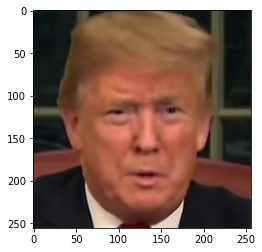

In [75]:
# obtain original image from stenographic mask

transform = T.Compose([T.ToTensor()])

img_fake = cv2.cvtColor(cv2.imread('./vision/cycle_gan/results/'+str(styles[style_index])+'/test_latest/images/'+str(1)+'_fake.png'), cv2.COLOR_BGR2RGB)
img_rgb_fake = transform(img_fake)
img_array_floating_fake = np.array(img_rgb_fake[:,:,:])

# masked_img_array

# restoring original from (fake, mask)
restored_img = []
for j in range(img_rgb_fake.shape[2]): # for each pixel along width
    sub_masked_img = []
    for i in range(img_rgb_fake.shape[1]): # for each pixel along height
        tmp=[]
        for h in range(img_rgb_fake.shape[0]): # for each image channel
            tmp.append(img_array_floating_fake[h][j][i]-masked_img_array[i][j][h])
        sub_masked_img.append(tmp)
    restored_img.append(sub_masked_img) 

restored_img_array = np.array(restored_img)

if display == True:
    print("Restored image")
    plt.imshow(restored_img_array)
    plt.show()